In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.integrate import odeint as odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('elkwolves.txt', sep=' ' )
df.head()

,Year,Elk,Wolves
0,1995,16250,21
1,1996,16250,24
2,1997,13500,32
3,1998,11700,48
4,1999,11750,44


In [18]:
def next_state(state, t, thetas):
    x, y = state
    a, b, c, d, K = thetas
    
    xPrime = (a * x * (1 - (x / K))) - (b * x * y)
    yPrime = (-1 * (c * y)) + (d * x * y)

    newState = [xPrime, yPrime]
    return newState 


def gen_modelmap(thetas):
    ts = df["Year"].to_numpy()
    initial_state = np.array([df["Elk"][0], df["Wolves"][0]])

    model_map = odeint(next_state, initial_state, ts, args=(thetas,))
    model_map = np.array(model_map)

    return model_map

def get_residuals(thetas):
    model_map = gen_modelmap(thetas)
    resids = model_map - df[["Elk", "Wolves"]].to_numpy()
    resids = resids.flatten()
    return resids

In [4]:
df = df - df.mean()
df = df / df.std()
df = df - df.min() + 0.01

/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


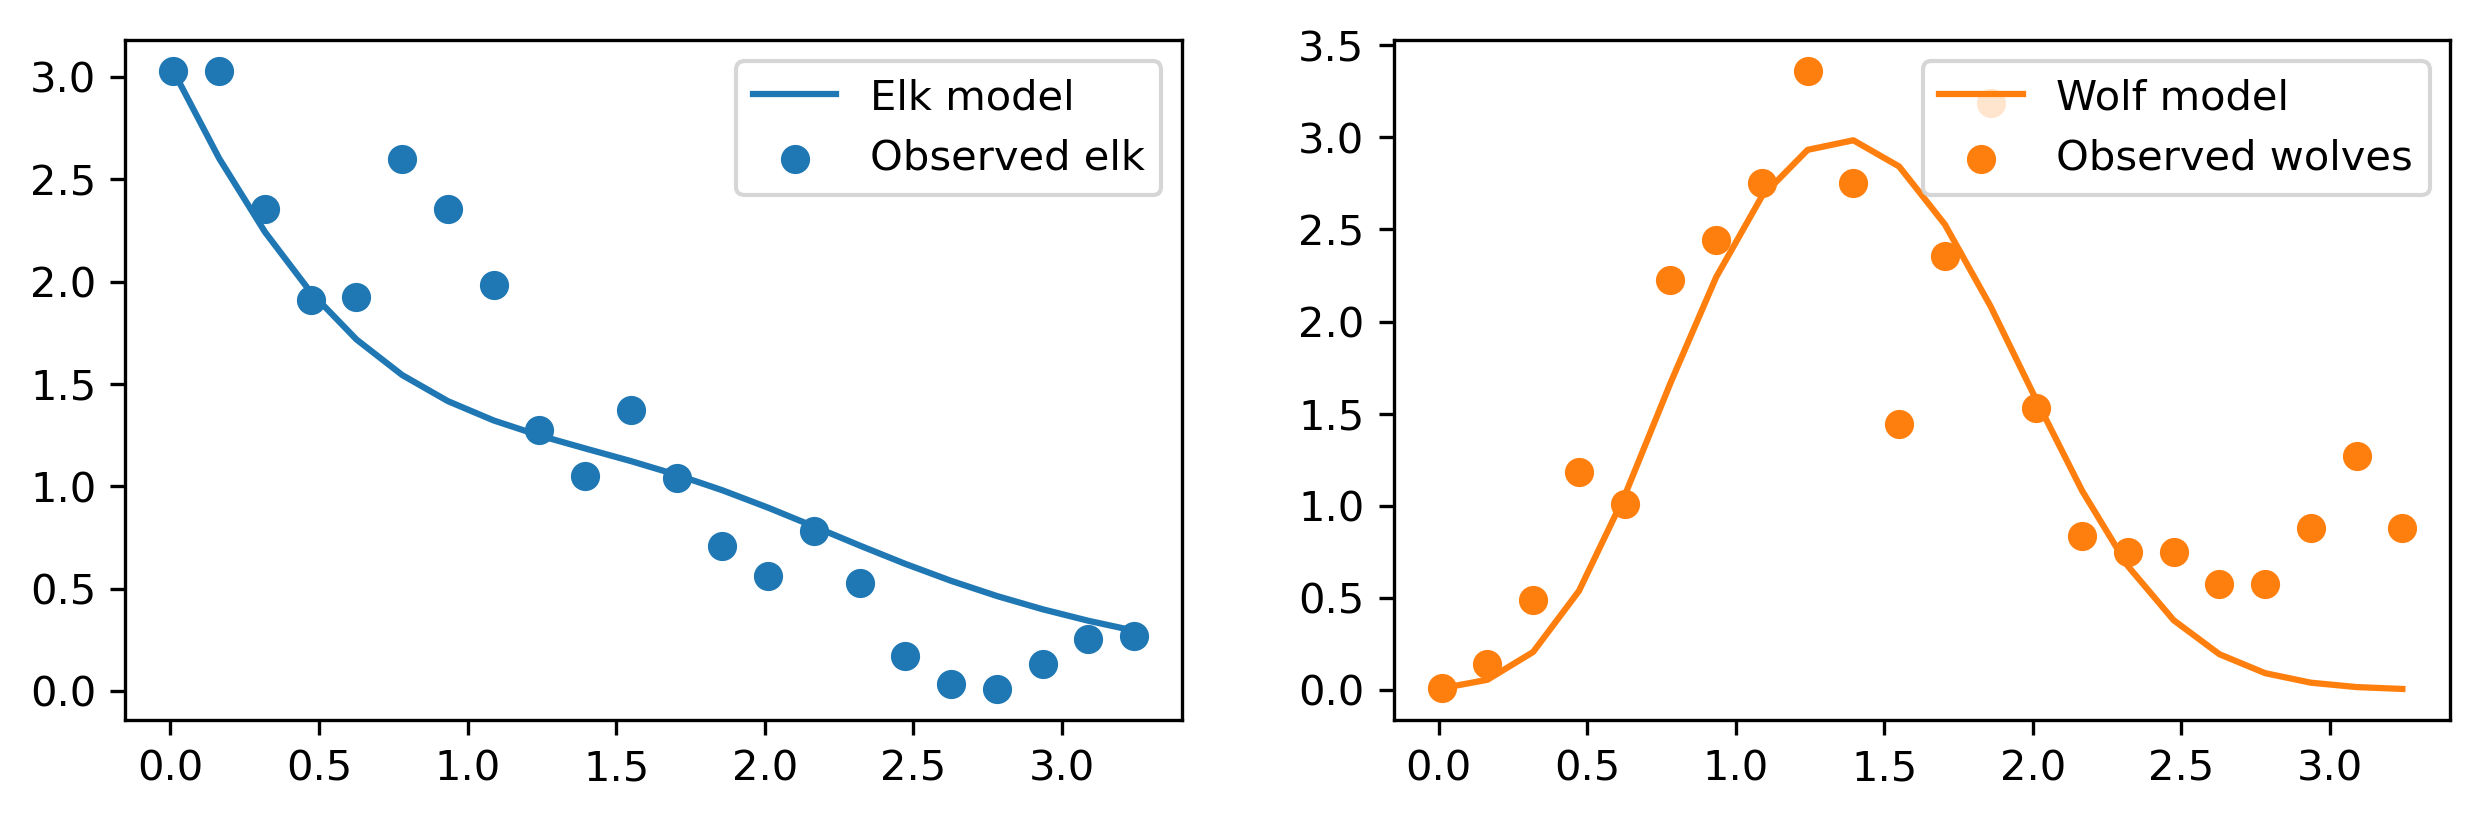

In [53]:
theta_init = np.random.standard_normal(5)
residuals = get_residuals(theta_init)

res = least_squares(get_residuals, theta_init, method="lm")
opt_theta = res["x"]
cost = res["cost"]

model_map = gen_modelmap(opt_theta)

fig, axes = plt.subplots(1,2, figsize=(10,3), dpi=300)
axes[0].plot(df["Year"], model_map.T[0], label="Elk model")
axes[0].scatter(df["Year"], df["Elk"], label="Observed elk")
axes[0].legend()

axes[1].plot(df["Year"], model_map.T[1], label="Wolf model",c='tab:orange')
axes[1].scatter(df["Year"], df["Wolves"], label="Observed wolves",c='tab:orange')
axes[1].legend()

plt.show()

/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/jakecallahan/opt/anaconda3/envs/580/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


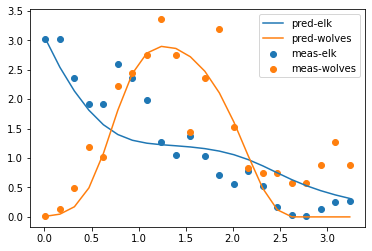

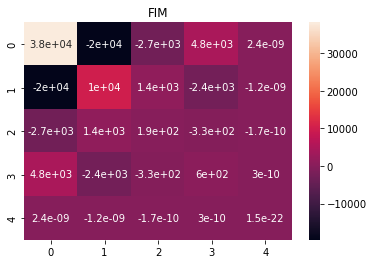

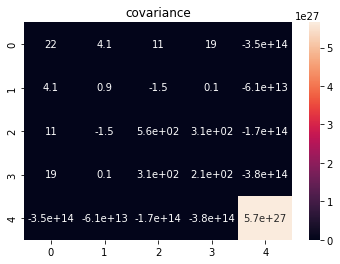

In [6]:
def predict(state, dt, thetas):
    xk, yk = state
    a, b, c, d, K = thetas 
    
    # compute the change in state
    xkplus = ((1 + (dt * a)) * xk) + (-1 * dt * b * xk * yk) + (-1 * ((dt * a) / K) * xk * xk)
    ykplus = ((1 - (dt * c)) * yk) + (dt * d * xk * yk)

    newState = [xkplus, ykplus] # notice that this is different than in the continuous case
    return newState 


def getModelMap(thetas):
    ts = df["Year"].to_numpy()
    initialState = np.array([df["Elk"][0],df["Wolves"][0]])

    modelMap = np.empty((ts.shape[0], initialState.shape[0]))
    modelMap[0] = initialState

    nextState = initialState
    for index in range(1, ts.shape[0]):
        dt = ts[index - 1] - ts[index] # get the change in time
        nextState = predict(nextState, dt, thetas)
        modelMap[index] = nextState
    return modelMap

def getResiduals(thetas):
    modelMap = getModelMap(thetas)
    residuals = modelMap - df[["Elk", "Wolves"]].to_numpy()
    residuals = residuals.flatten()
    return residuals
    

thetasInit = np.random.standard_normal(5)
residuals = getResiduals(thetasInit)

result = least_squares(getResiduals, thetasInit, method="lm")
thetasStar = result["x"]
cost = result["cost"]

modelMap = getModelMap(thetasStar)

plt.plot(df["Year"], modelMap.T[0], label="pred-elk")
plt.plot(df["Year"], modelMap.T[1], label="pred-wolves")
plt.scatter(df["Year"], df["Elk"], label="meas-elk")
plt.scatter(df["Year"], df["Wolves"], label="meas-wolves")
plt.legend()
plt.show() 


J = result.jac
J @ J.T

sigmaSquared = ((result.cost * 2) / (np.sqrt(len(df["Year"]) - thetasStar.shape[0]))) ** 2
FIM =  J.T @ J * (1 / sigmaSquared)
cov = np.linalg.inv(FIM)

sns.heatmap(FIM, annot=True)
plt.title("FIM")
plt.show()
sns.heatmap(cov, annot=True)
plt.title("covariance")
plt.show()